In [1]:
!pip install geoopt

!git clone https://github.com/hchau630/LSC
%cd LSC

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as f
# import importlibs
import torchvision
import torchvision.datasets as datasets
import time
import lsc
import sc
import matplotlib.animation as animation
import utils
import image_transform as img_tran
import os
import shutil
import geoopt

     |████████████████████████████████| 85 kB 3.2 MB/s 
Cloning into 'LSC'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 645 (delta 6), reused 7 (delta 2), pack-reused 624
Receiving objects: 100% (645/645), 432.11 MiB | 24.09 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/LSC


In [2]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
torch.cuda.set_device(0) #use GPU 0

In [3]:
def plot_psi(psi, rgb=False, show=False, save=None, box_margins=[0.05,0.95,0.95,0.05]):
    fig = plt.figure(figsize=(10,int(K/10)))
    for k in range(K):
        fig.add_subplot(int(K/10),10,k+1)
        plt.xticks([])
        plt.yticks([])
        if rgb:
            plt.imshow((psi[:,k]/psi[:,k].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
        else:
            plt.imshow(psi[:,k].reshape(dim,dim).cpu(), cmap="Greys")
#     plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, left=box_margins[0], right=box_margins[1], top=box_margins[2], bottom=box_margins[3])
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)

def plot_w(w, rgb=False, show=False, save=None, cols=16):
    fig = plt.figure(figsize=(cols,int(L*2/cols)))
    for i in range(L*2):
        fig.add_subplot(int(L*2/cols),cols,i+1)
        plt.xticks([])
        plt.yticks([])
        if rgb:
            plt.imshow((w[:,i]/w[:,i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
        else:
            plt.imshow(w[:,i].reshape(dim,dim).cpu(), cmap="Greys")
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)
    
def plot_operator(s_ratio, show=False, save=None, use_psi=False, rgb=False, rmin=-np.pi, rmax=np.pi, N_figs=19, K=10, box_margins=[0.05,0.95,0.95,0.05], hspace=0.0,wspace=0.0):
    if use_psi:
        x = psi[:,:K].clone().t()
    else:
        x = next(iter(test_dl))[:K]

    w1, w2 = w[:,::2], w[:,1::2] # (D,L), (D,L)
    u1 = torch.einsum('dj, bd -> bj', w1, x) # (B,L)
    u2 = torch.einsum('dj, bd -> bj', w2, x) # (B,L)

    y_hat = torch.zeros(K,N_figs,D)
    for j in range(N_figs):
        s = torch.from_numpy(np.array(s_ratio)*np.linspace(rmin, rmax, num=N_figs)[j]).cuda()
        m_hat = torch.einsum('jn,n->j',omega.float(), s.float())
        ru1, ru2 = lsc.rot(m_hat.float(), u1, u2)
        ru = torch.zeros((K,L*2)).cuda() # (K,L*2) = (B,L*2)
        ru[:,::2] = ru1
        ru[:,1::2] = ru2
        y_hat[:,j,:] = torch.einsum('dj, bj -> bd', w, ru) # (B,D)

    fig = plt.figure(figsize=(N_figs,K))
    for i in range(K):
        for j in range(N_figs):
            fig.add_subplot(K,N_figs,i*N_figs+j+1)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((y_hat[i,j]/y_hat[i,j].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(y_hat[i,j].reshape(dim,dim).cpu(), cmap="Greys", vmin=y_hat[:,j].min().cpu(), vmax=y_hat[:,j].max().cpu())
#     plt.tight_layout()
    plt.subplots_adjust(wspace=wspace,hspace=hspace,left=box_margins[0],right=box_margins[1],top=box_margins[2],bottom=box_margins[3])
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)
    
def plot_reconstruction(dl, alpha_0=0.01, show=False, save=None, three_d=False, plot_marginals=False,rgb=False,N=100,expanded=False,M=30):
    # Generate Data
    y = next(iter(dl))[:M]
    if k is not None and m is not None:
        mod_k, mod_m = k[:M], m[:M]
    else:
        mod_k, mod_m = None, None

    alpha = torch.ones(M,K).cuda()*alpha_0
    alpha = lsc.alpha_update_FISTA(y, psi, w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=plot, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

    # Calculate useful variables (This and following parts total: 0.015s)
    x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, psi, w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)
    
    nll = -lsc.log_likelihood(x, y, u, v, psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
    
    unique_omega = torch.unique(omega, dim=0) # (L,n)
    post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N) # (M,N,N)
    s_hat = utils.get_MAP(post)
    recon = lsc.reconstruct(x, w, s_hat, omega)
    
    if expanded:
        cols = 3+omega.size()[1]+psi.size()[1]
        fig = plt.figure(figsize=(cols,M))
        for i in range(M):
            fig.add_subplot(M,cols,i*cols+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(y[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(M,cols,i*cols+1+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(recon[i].cpu().reshape((dim,dim)),cmap="Greys")
            marginals = utils.marginalize_distribution(post) # (K,N,n)
            t = np.linspace(-np.pi,np.pi,num=marginals.shape[1])
            for j in range(omega.size()[1]):
                fig.add_subplot(M,cols,i*cols+1+1+j+1)
                plt.xticks(ticks=[-np.pi,0,np.pi],labels=[r'$-\pi$',0,r'$\pi$'])
                plt.yticks([])
                plt.plot(t,marginals[i,:,j])
            fig.add_subplot(M,cols,i*cols+1+1+omega.size()[1]+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(torch.einsum('dk,k->d',psi,alpha[i]).cpu().reshape((dim,dim)),cmap="Greys")
            vmin, vmax = torch.min(torch.einsum('dk,k->dk',psi,alpha[i])), torch.max(torch.einsum('dk,k->dk',psi,alpha[i]))
            for j in range(psi.size()[1]):
                fig.add_subplot(M,cols,i*cols+1+1+omega.size()[1]+1+j+1)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(psi[:,j].cpu().reshape((dim,dim))*alpha[i,j],vmin=vmin,vmax=vmax,cmap="Greys")
        plt.tight_layout(h_pad=0.0,w_pad=0.0)
    else:
        if three_d:
            tx, ty = np.linspace(-np.pi, np.pi, num=post.shape[1]), np.linspace(-np.pi, np.pi, num=post.shape[2])
            gx, gy = np.meshgrid(tx, ty)
        if plot_marginals:
            marginals = utils.marginalize_distribution(post) # (K,N,n)
            t = np.linspace(-np.pi,np.pi,num=marginals.shape[1])
        nfigs = 4 + omega.size()[1] if plot_marginals else 5
        cols = nfigs*3
        fig = plt.figure(figsize=(cols,10))
        for i in range(M):
            fig.add_subplot(10,cols,i*nfigs+1)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((y[i]/y[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(y[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+2)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((recon[i]/recon[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(recon[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+3)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((x[i]/x[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(x[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+4)
            plt.xticks([])
            plt.yticks([])
            plt.bar(np.arange(alpha.size()[1]), alpha[i].cpu())
            if three_d:
                ax = fig.add_subplot(10,cols,i*nfigs+5, projection='3d')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
                ax.plot_surface(gx, gy, post[i])
            elif plot_marginals:
    #             print(marginals.shape)
                for j in range(omega.size()[1]):
                    fig.add_subplot(10,cols,i*nfigs+5+j)
                    plt.yticks([])
                    plt.plot(t,marginals[i,:,j])
            else:
                fig.add_subplot(10,cols,i*nfigs+5)
                plt.xticks([])
                plt.yticks([])
                plt.bar(np.arange(s_hat.size()[1]), s_hat[i].cpu())
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)
    
def save_loss(train_loss, test_loss, save):
    f = open(save, 'a')
    np.savetxt(f, np.array([train_loss, test_loss])[np.newaxis,:])
    f.close()
    
def plot_loss(load,show=True,save=None,validation_only=True):
    losses = np.loadtxt(load)
    train_loss, test_loss = losses[:,0], losses[:,1]
    eps = len(train_loss)
    if validation_only:
        plt.plot(np.arange(eps),test_loss,label="Validation Loss")
    else:
        plt.plot(np.arange(eps),train_loss,label="Training Loss")
        plt.plot(np.arange(eps),test_loss,label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Negative Log Likelihood)")
    if save:
        plt.savefig(save)
    if show:
        plt.show()
        
def get_MNIST_dataloader(B, cuda=False, dim=28):
    # Load mnist dataset.
#     transform = torchvision.transforms.Compose([
#         torchvision.transforms.ToTensor()
#     ])
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((dim,dim)),
        torchvision.transforms.ToTensor()
    ])
    mnist_trainset = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
    mnist_testset = datasets.MNIST(root='./datasets', train=False, download=True, transform=transform)
    trainset_size = len(mnist_trainset)
    testset_size = len(mnist_testset)
    train_dl = torch.utils.data.DataLoader(dataset=mnist_trainset, batch_size=trainset_size, shuffle=True)
    test_dl = torch.utils.data.DataLoader(dataset=mnist_testset, batch_size=testset_size, shuffle=True)
    
    num_train_batches, num_test_batches = trainset_size//B, testset_size//B
    assert num_train_batches*B == trainset_size
    assert num_test_batches*B == testset_size
    
    dim = next(iter(train_dl))[0].squeeze().size()[1]
    D = dim*dim
    new_train_dl = next(iter(train_dl))[0].squeeze().view(num_train_batches,B,D).cuda()
    new_test_dl = next(iter(test_dl))[0].squeeze().view(num_test_batches,B,D).cuda()
    
    new_train_dl = f.normalize(new_train_dl,dim=2)
    new_test_dl = f.normalize(new_test_dl,dim=2)
    
    if cuda:
        return new_train_dl, new_test_dl, dim, D, num_train_batches, num_test_batches
    else:
        return new_train_dl.cpu(), new_test_dl.cpu(), dim, D, num_train_batches, num_test_batches
    
class CustomDataLoader:
    def __init__(self, dataloader, B, D):
        self.dataloader = dataloader
        self.B = B
        self.D = D
    def __iter__(self):
        self.it = iter(self.dataloader)
        return self
    def __next__(self):
        try:
            batch = next(self.it)[0].view(self.B,self.D).cuda()
            return f.normalize(batch,dim=1)
        except StopIteration:
            raise StopIteration
            
def get_custom_dataloader(B, train_l=6000, test_l=1000, dx=[0.0,0.0], dy=[0.0,0.0], dr=[0.0,0.0], ds=[1.0,1.0], thicken=False, wrap=False, shuffle=True, cuda=False, dim=28):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((dim,dim)),
        torchvision.transforms.ToTensor()
    ])
    mnist_trainset = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
    mnist_dl = torch.utils.data.DataLoader(dataset=mnist_trainset, batch_size=1000, shuffle=False)
    batch = next(iter(mnist_dl))
    y = batch[0].squeeze() # (1000,dim,dim)
    labels = batch[1] # (1000)
    dl_batch_size, dim = y.size()[0], y.size()[1]
    center = ((dim)/2,(dim)/2)
    D = dim*dim
    N = 10
    num_train_batches, num_test_batches = N*train_l//B, N*test_l//B
    assert num_train_batches*B == N*train_l
    assert num_test_batches*B == N*test_l
    
    y = y.view(dl_batch_size,D)
    digits = torch.zeros((N,D))
    for i in range(10):
        idx = labels == i
        digits[i*(N//10):(i+1)*(N//10)] = y[idx][:(N//10)]
#         digits[i:i+1] = y[idx][np.random.choice(len(y[idx]))]

    train_video = torch.zeros(N,train_l,D)
    for i, digit in enumerate(digits):
        shift_x = torch.from_numpy(np.random.uniform(dim*dx[0],dim*dx[1],train_l))
        shift_y = torch.from_numpy(np.random.uniform(dim*dy[0],dim*dy[1],train_l))
        rotation = torch.from_numpy(np.random.uniform(dr[0],dr[1],train_l))
        scaling = torch.from_numpy(np.random.uniform(ds[0],ds[1],train_l))
        x = digit.repeat(train_l,1).view(train_l,dim,dim)
        y = img_tran.affine_2D(x, shift_x, shift_y, rotation, scaling, wrap_around=wrap)
        if thicken:
            sigma = torch.from_numpy(np.random.uniform(0.01,1.0,train_l))
            y = img_tran.thicken(y, sigma)
        train_video[i] = y.view(train_l,D)
        
    test_video = torch.zeros(N,test_l,D)
    for i, digit in enumerate(digits):
        shift_x = torch.from_numpy(np.random.uniform(dim*dx[0],dim*dx[1],test_l))
        shift_y = torch.from_numpy(np.random.uniform(dim*dy[0],dim*dy[1],test_l))
        rotation = torch.from_numpy(np.random.uniform(dr[0],dr[1],test_l))
        scaling = torch.from_numpy(np.random.uniform(ds[0],ds[1],test_l))
        x = digit.repeat(test_l,1).view(test_l,dim,dim)
        y = img_tran.affine_2D(x, shift_x, shift_y, rotation, scaling, wrap_around=wrap)
        if thicken:
            sigma = torch.from_numpy(np.random.uniform(0.01,1.0,test_l))
            y = img_tran.thicken(y, sigma)
        test_video[i] = y.view(test_l,D)
    
    train_video = f.normalize(train_video.view(N*train_l,D).cuda(),dim=1)
    test_video = f.normalize(test_video.view(N*test_l,D).cuda(),dim=1)
    
    if shuffle:
        train_video = train_video[torch.randperm(N*train_l)]
        test_video = test_video[torch.randperm(N*test_l)]
    
    if cuda:
        return train_video.view(num_train_batches,B,D), test_video.view(num_test_batches,B,D), dim, D, num_train_batches, num_test_batches
    else:
        return train_video.view(num_train_batches,B,D).cpu(), test_video.view(num_test_batches,B,D).cpu(), dim, D, num_train_batches, num_test_batches
    
def initialize_omega(n, L, o_max, multiplicity):
    if n == 1:
        omega = torch.arange(o_max).cuda().int().unsqueeze(1) # (ceil(o_max),1)
    elif n == 2: # n == 2
        omega_x = torch.arange(o_max).cuda() # (ceil(o_max))
        omega_y = torch.arange(-int(o_max), o_max).cuda() # (2*ceil(o_max)-1)
        omega = torch.stack(torch.meshgrid(omega_x, omega_y),dim=2).view(-1,2) # get list of points
        omega = omega[omega.float().norm(dim=1) <= o_max] # select points inside circle with radius o_max
        omega = omega[(omega[:,1] >= 0) + (omega[:,0] != 0)] # remove points on y-axis with negative y coordinates
        # sort by radius first, then by angle
        omega = torch.from_numpy(np.array(sorted(omega.cpu().numpy(),key=lambda x: (np.sum(x**2),np.arctan2(x[1],x[0]))))).cuda().int()
    else:
        omega_n = torch.arange(-int(o_max), o_max).cuda().repeat(n,1) # (n,2*ceil(o_max)-1)
        omega = torch.stack(torch.meshgrid(*omega_n),dim=n).view(-1,n) # ((2*ceil(o_max)-1)^n,n)
        omega = omega[omega.float().norm(dim=1) <= o_max].cpu().numpy() # select points inside n-sphere with radius o_max
        filtered_omega = []
        for o in omega:
            if tuple(-o) not in filtered_omega:
                filtered_omega.append(tuple(o))
        omega = torch.from_numpy(np.array(sorted(np.array(filtered_omega),key=lambda x: np.sum(x**2)))).cuda().int()
    omega = omega.repeat_interleave(multiplicity,dim=0) # multiplicity of irreps
    omega = omega[:L] # select the first L points # (L,n)
    return omega

# Show custom dataset

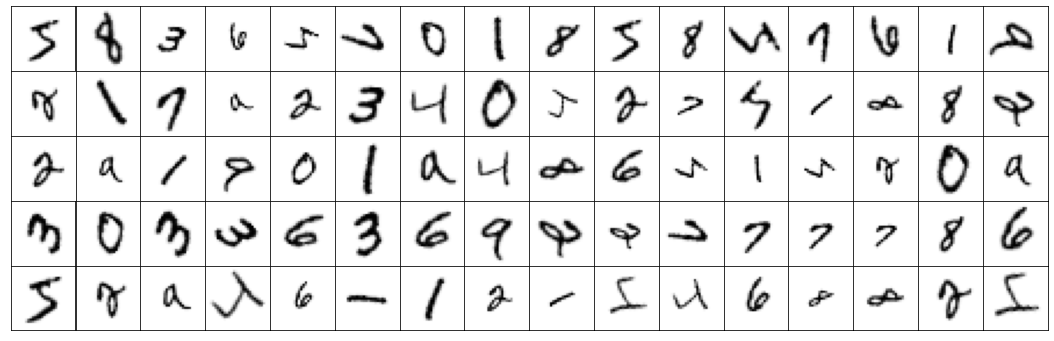

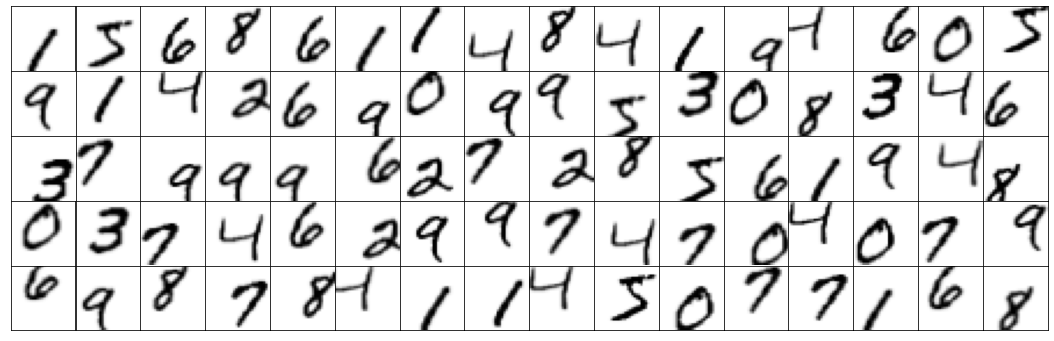

In [4]:
B = 100
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dr=[-75.0,75.0],ds=[0.5,1.0],cuda=True) # Rotation and Scaling
it = iter(dl)
y = next(it)
fig = plt.figure(figsize=(16,5))
for i in range(80):
    fig.add_subplot(5,16,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y[i].reshape(dim,dim).cpu().numpy(), cmap="Greys")
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.0,hspace=0.0)
# plt.tight_layout(h_pad=0.0,w_pad=0.0)
plt.show()
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dx=[-0.25,0.25],dy=[-0.25,0.25],cuda=True) # Horizontal and Vertical Translation
it = iter(dl)
y = next(it)
fig = plt.figure(figsize=(16,5))
for i in range(80):
    fig.add_subplot(5,16,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y[i].reshape(dim,dim).cpu().numpy(), cmap="Greys")
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.0,hspace=0.0)
# plt.tight_layout(h_pad=0.0,w_pad=0.0)
plt.show()

# Training the network

In [5]:
def create_w_learning_rate_adjuster(initial_lr, final_lr, warmup_steps):
    def adjust_w_learning_rate(optimizer, step):
        if step < warmup_steps:
            t = step / warmup_steps
            lr = (1-t)*initial_lr + t*final_lr
        else:
            lr = final_lr
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    return adjust_w_learning_rate

def create_psi_learning_rate_adjuster(initial_lr, final_lr, warmup_steps):
    def adjust_psi_learning_rate(step):
        if step < warmup_steps:
            t = step / warmup_steps
            lr = (1-t)*initial_lr + t*final_lr
        else:
            lr = final_lr
        return lr
    
    return adjust_psi_learning_rate

**Initialization**

In [6]:
B = 100

# Initialize dataloader
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_MNIST_dataloader(B,cuda=True)
# dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dr=[-75.0,75.0],ds=[0.5,1.0],cuda=True) # Rotation and Scaling
# dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dx=[-0.25,0.25],dy=[-0.25,0.25],cuda=True) # Horizontal and Vertical Translation

# Initialize omega
# L = 128
# o_max = 9.5
# multiplicity = 1
# n = 2
L = 128
o_max = 6.5
multiplicity = 2
n = 2
omega = initialize_omega(n,L,o_max,multiplicity)
assert omega.size()[0] == L

# Initialize sparse coding dictionary
K = 100
psi = torch.rand(D,K).cuda() # (D,K)
psi = f.normalize(psi, dim=0)

# Initialize weights
pre_w = torch.rand(D, L*2).cuda() # (D,J*2)
pre_w = lsc.orthogonalize(pre_w)
w_manifold = geoopt.manifolds.Stiefel()
w = geoopt.ManifoldParameter(pre_w,manifold=w_manifold,requires_grad=False)

# Initialize alpha
alpha_0 = 0.01
alpha = torch.ones(B,K).cuda()*alpha_0

k, m = None, None

epoch, T = 0, 0

**Parameters**

In [7]:
# Tunable parameters
eta_psi = 0.05
eta_w = 0.3
warmup_epochs = 3
adjust_psi_learning_rate = create_psi_learning_rate_adjuster(0.0, eta_psi, warmup_epochs*num_train_batches)
adjust_w_learning_rate = create_w_learning_rate_adjuster(0.0, eta_w, warmup_epochs*num_train_batches)
w_optimizer = geoopt.optim.RiemannianAdam([w], lr=eta_w)
unique_omega = torch.unique(omega, dim=0) # (L,n)
s = 0.1
lamb = 1.0 # sparsity cost
lamb2 = 0.0 # slow feature cost 
lamb3 = 0.0 # psi regularization
epochs = 10 # 20000
save_skip = 100
steps = 20
N_samples = 100

# These options can be changed as needed.
test = True
save = True
annealing = False
shuffle = True
warmup = True

# The options below should not need to be changed.
adaptive = True
adaptive_steps = False
modified = False
video = False
map_est = False
rgb = False
plot = False

**File paths for saving data**

In [8]:
# dataset_type = "rot_75_scale_0.5-1.0_"
dataset_type = "ver_hor_"
# dataset_type = ""
if adaptive_steps:
    new_dir = "data/{}MNIST{}x{}/s{}_B{}_K{}_n{}_omegax{}_lamb{}_L{}_epsi{}_ew{}_steps_adaptive_samples{}_initalpha{}".format(dataset_type,dim,dim,s,B,K,n,multiplicity,lamb,L,eta_psi,eta_w,N_samples,alpha_0)
else:
    new_dir = "data/{}MNIST{}x{}/s{}_B{}_K{}_n{}_omegax{}_lamb{}_L{}_epsi{}_ew{}_steps{}_samples{}_initalpha{}".format(dataset_type,dim,dim,s,B,K,n,multiplicity,lamb,L,eta_psi,eta_w,steps,N_samples,alpha_0)
if annealing:
    new_dir = new_dir + "_annealing"
else:
    new_dir = new_dir + "_no_annealing"
if shuffle:
    new_dir = new_dir + "_shuffle"
if warmup:
    new_dir = new_dir + f"_warmup{warmup_epochs}"
new_dir = new_dir + "_5"
if save:
    if not os.path.isdir("data/{}MNIST{}x{}".format(dataset_type,dim,dim)):
        os.mkdir("data/{}MNIST{}x{}".format(dataset_type,dim,dim))
    os.mkdir(new_dir)
    os.mkdir(new_dir + "/data")
    os.mkdir(new_dir + "/figures")
    os.mkdir(new_dir + "/videos")
data_path = new_dir + "/data/{}_epoch_{}.txt"
fig_path = new_dir + "/figures/{}_epoch_{}.png"
video_path = new_dir + "/videos/{}_epoch_{}_batch_{}.mp4"

**Training loop**

In [9]:
while epoch < epochs:
    # Reload dataloader
    if shuffle:
        dl = dl.view(-1,dl.size()[-1])[torch.randperm(dl.size()[0]*dl.size()[1])].view(dl.size()) # shuffle
    it = iter(dl)
    test_it = iter(test_dl)
    
    # Training
    train_loss = 0.0
    train_snr = 0.0
    train_l1 = 0.0
    while T < num_train_batches:
        t = int(epoch*num_train_batches+T+1)
        
        if warmup:
            adjust_w_learning_rate(w_optimizer, t)
            eta_psi = adjust_psi_learning_rate(t)
            if T % save_skip == 0:
                print(f"w lr: {w_optimizer.param_groups[0]['lr']}, psi lr: {eta_psi}")
        
        # Get data (0.006s)
        y = next(it) # (B,D)

        # Optimize alpha (0.058s)
        alpha[...] = alpha_0
        alpha = lsc.alpha_update_FISTA(y, psi, w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=plot, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)
        
        # Calculate useful variables (This and following parts total: 0.015s)
        x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, psi, w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

        # Calculate error
        nll = -lsc.log_likelihood(x, y, u, v, psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
        train_loss += nll
        post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
        s_hat = utils.get_MAP(post)
        recon = lsc.reconstruct(x, w, s_hat, omega)
        train_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
        train_l1 += alpha.norm(dim=1, p=1).mean()
        
        # Update psi
        psi, dpsi_length = lsc.psi_update(psi, alpha, tres, s, eta_psi, lamb3, modified=modified)
    
        # Update W
        w, dw_length = lsc.w_update_riemann(w_optimizer, x, w, q, res, s, modified=modified)
        
        if video and T % 600 == 0:
            reconstruction_video(test_dl, steps, video_path.format("inference",epoch,T), three_d=True, s_only=False,i=np.random.randint(B))
        # Print error
        if T % save_skip == 0:
            print("Epoch {}, Batch {}: Train loss - {:.3f};  Psi - {:.3f}; W - {:.3f}".format(epoch, T, nll, dpsi_length, dw_length))
        
        T += 1
    
    train_loss /= num_train_batches
    train_snr /= num_train_batches
    train_l1 /= num_train_batches
    T = 0
    
    # Validation
    if test:
        test_loss = 0.0
        test_snr = 0.0
        test_l1 = 0.0
        normed_psi = f.normalize(psi,dim=0)
        while T < num_test_batches:
            # Generate data
            y = next(test_it)

            # Optimize alpha
            alpha[...] = alpha_0
            alpha = lsc.alpha_update_FISTA(y, normed_psi, w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=False, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

            # Calculate useful variables
            x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, normed_psi, w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)

            # Calculate error
            test_loss += -lsc.log_likelihood(x, y, u, v, normed_psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
            post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N_samples) # (M,N,N)
            s_hat = utils.get_MAP(post)
            recon = lsc.reconstruct(x, w, s_hat, omega)
            test_snr += ((y**2).sum(dim=1)/((y-recon)**2).sum(dim=1)).mean()
            test_l1 += alpha.norm(dim=1, p=1).mean()
            T += 1
            
        test_loss /= num_test_batches
        test_snr /= num_test_batches
        test_l1 /= num_test_batches
        T = 0
        print("Epoch {}: Test loss - {:.3f}; SNR - {:.3f}; L1 - {:.3f}; ".format(epoch, test_loss, test_snr, test_l1))
    
    epoch += 1
    if epoch % 20 == 0 and annealing:
        eta_psi /= 2.0
        eta_w /= 2.0
        w_optimizer = geoopt.optim.RiemannianAdam([w], lr=eta_w)
    
    if save and test:
        # Save data
        np.savetxt(data_path.format("psi",epoch), psi.cpu().numpy())
        np.savetxt(data_path.format("w",epoch), w.cpu().numpy())
        save_loss(train_loss, test_loss, new_dir + "/data/loss.txt")
        save_loss(train_snr, test_snr, new_dir + "/data/snr.txt")
        save_loss(train_l1, test_l1, new_dir + "/data/l1_norm.txt")

        # Plot figures
        plot_psi(psi,save=fig_path.format("psi",epoch),rgb=rgb)
        plot_w(w,save=fig_path.format("w",epoch),rgb=rgb)
#         plot_w(w,save=fig_path.format("w",epoch),rgb=rgb,cols=10)
        for i in range(n):
            si = np.zeros(n)
            si[i] = 1.0
            plot_operator(si,save=fig_path.format("op{}".format(i+1),epoch),rgb=rgb)
        plot_reconstruction(test_dl,save=fig_path.format("recon",epoch),rgb=rgb,plot_marginals=True,N=N_samples)

w lr: 0.00016666666666666666, psi lr: 2.777777777777778e-05


/content/LSC/lsc.py:210: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  lipschitz = 1.5*torch.max(torch.symeig(torch.mm(wpsi.t(),wpsi),eigenvectors=False)[0])/sigma**2


Epoch 0, Batch 0: Train loss - 49.337;  Psi - 0.000; W - 0.000
w lr: 0.016833333333333332, psi lr: 0.002805555555555556
Epoch 0, Batch 100: Train loss - 39.351;  Psi - 0.000; W - 0.014
w lr: 0.033499999999999995, psi lr: 0.005583333333333333
Epoch 0, Batch 200: Train loss - 36.559;  Psi - 0.001; W - 0.013
w lr: 0.050166666666666665, psi lr: 0.00836111111111111
Epoch 0, Batch 300: Train loss - 32.724;  Psi - 0.001; W - 0.017
w lr: 0.06683333333333333, psi lr: 0.01113888888888889
Epoch 0, Batch 400: Train loss - 29.874;  Psi - 0.001; W - 0.017
w lr: 0.08349999999999999, psi lr: 0.013916666666666667
Epoch 0, Batch 500: Train loss - 27.637;  Psi - 0.002; W - 0.022
Epoch 0: Test loss - 25.125; SNR - 3.805; L1 - 1.731; 
w lr: 0.10016666666666667, psi lr: 0.016694444444444446
Epoch 1, Batch 0: Train loss - 25.304;  Psi - 0.002; W - 0.024
w lr: 0.11683333333333332, psi lr: 0.019472222222222224
Epoch 1, Batch 100: Train loss - 23.129;  Psi - 0.003; W - 0.026
w lr: 0.1335, psi lr: 0.022250000000

# Plots

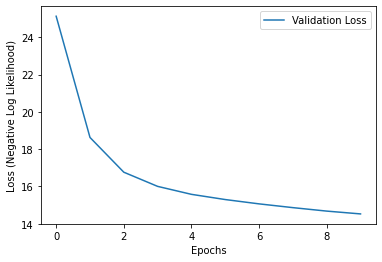

In [10]:
plot_loss(new_dir + "/data/loss.txt",show=True,save=new_dir+"/figures/loss.png",validation_only=True)

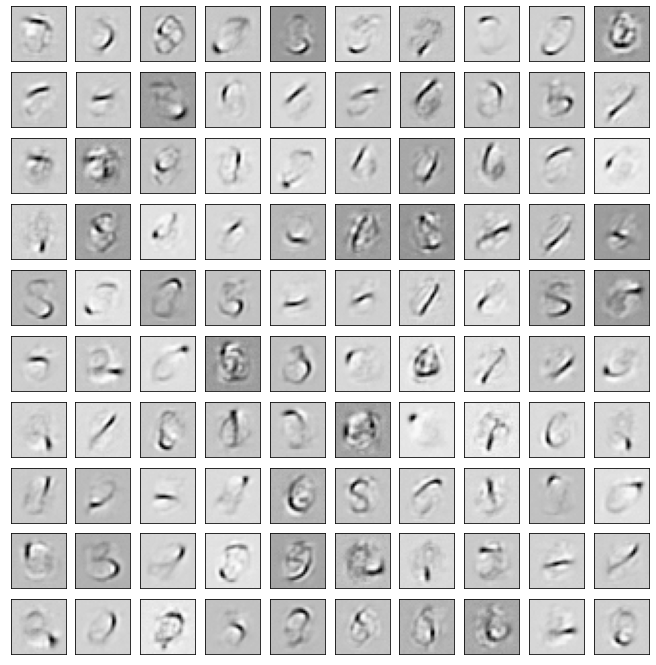

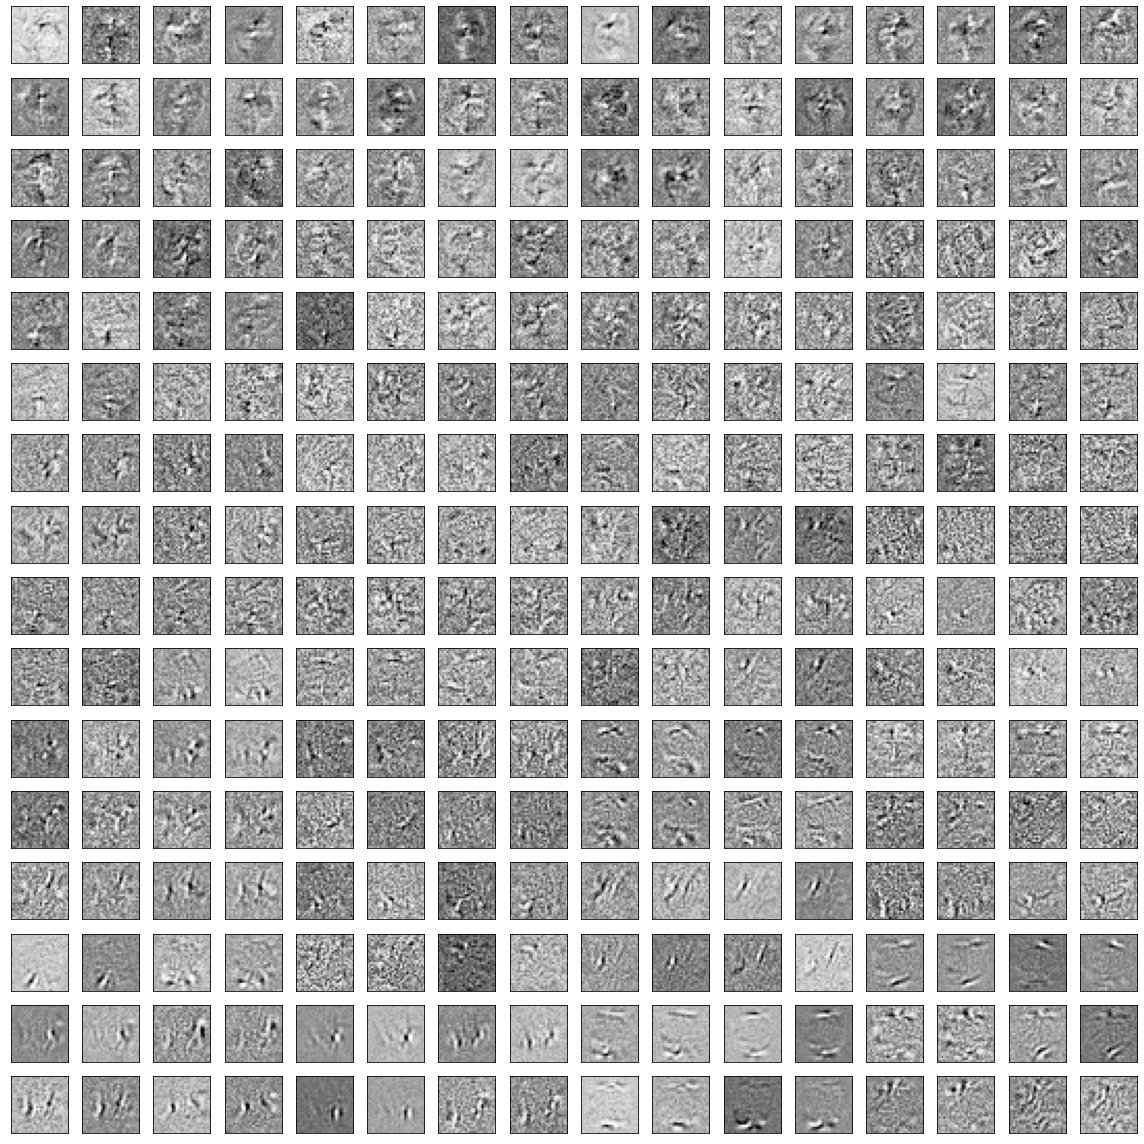

In [11]:
plot_psi(psi, show=True, rgb=False)
plot_w(w, show=True, rgb=False)
# plot_w(w, show=True, rgb=False, cols=10)

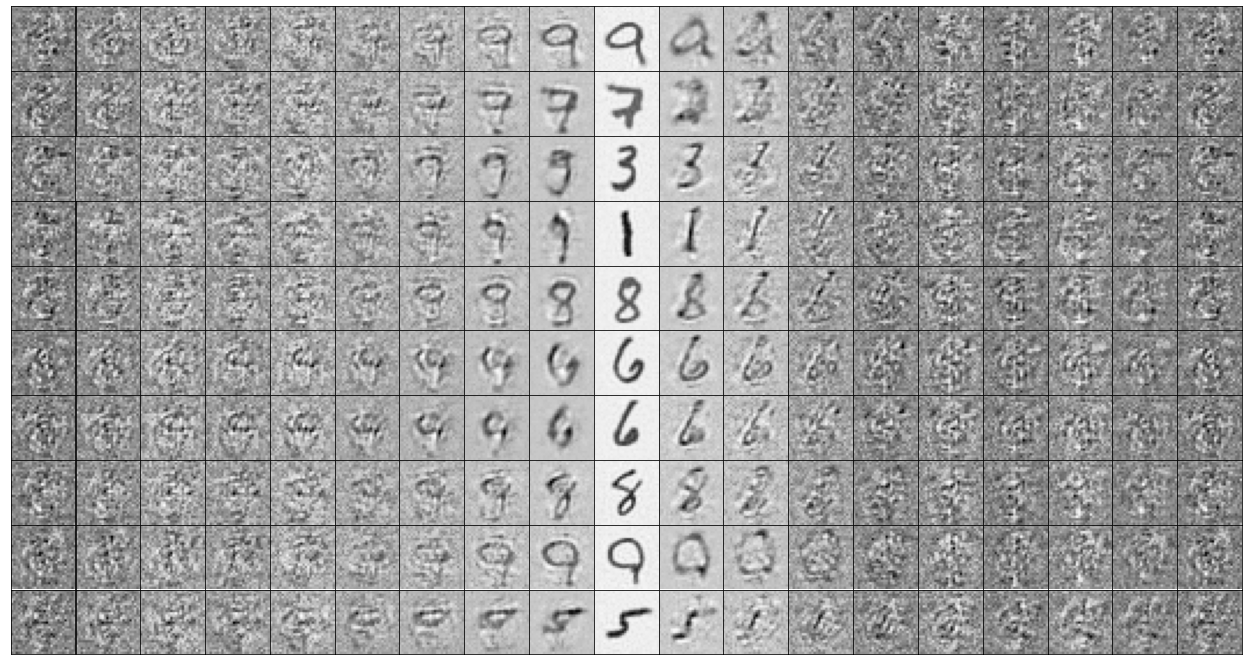

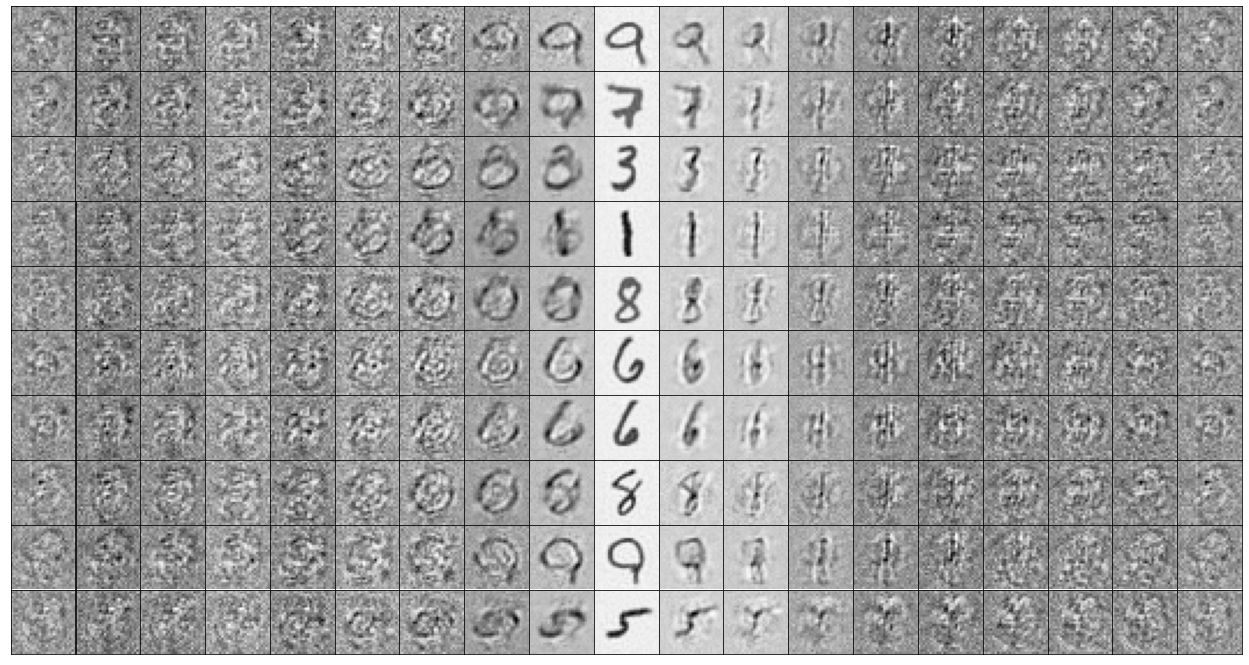

In [12]:
theta1 = 0.0*np.pi/180
theta2 = theta1 + 90.0*np.pi/180
s1 = np.array([np.cos(theta1),np.sin(theta1)])
s2 = np.array([np.cos(theta2),np.sin(theta2)])
s1 = s1 / np.max(np.abs(s1))
s2 = s2 / np.max(np.abs(s2))

plot_operator(s1,show=True, rgb=False)
plot_operator(s2,show=True, rgb=False)

In [28]:
def plot_reconstruction(dl, alpha_0=0.01, show=False, save=None, three_d=False, plot_marginals=False,rgb=False,N=100,expanded=False,M=30):
    # Generate Data
    y = next(iter(dl))[:M]
    if k is not None and m is not None:
        mod_k, mod_m = k[:M], m[:M]
    else:
        mod_k, mod_m = None, None

    alpha = torch.ones(M,K).cuda()*alpha_0
    alpha = lsc.alpha_update_FISTA(y, psi, w, omega, alpha, s, lamb, lamb2, steps, k=k, m=m, N=N_samples, modified=modified, plot=plot, map_est=map_est, adaptive=adaptive, adaptive_steps=adaptive_steps)

    # Calculate useful variables (This and following parts total: 0.015s)
    x, u, v, k_hat, m_hat, q, res, tres = lsc.compute_aux_var(y, psi, w, alpha, omega, s, k=k, m=m, N=N_samples, map_est=map_est)
    
    nll = -lsc.log_likelihood(x, y, u, v, psi, alpha, k_hat, m_hat, omega, lamb, lamb3, s, mean=True, N=N_samples, modified=modified, map_est=False)
    
    unique_omega = torch.unique(omega, dim=0) # (L,n)
    post = utils.get_distribution(k_hat, m_hat, unique_omega, N=N) # (M,N,N)
    s_hat = utils.get_MAP(post)
    recon = lsc.reconstruct(x, w, s_hat, omega)
    
    if expanded:
        cols = 3+omega.size()[1]+psi.size()[1]
        fig = plt.figure(figsize=(cols,M))
        for i in range(M):
            fig.add_subplot(M,cols,i*cols+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(y[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(M,cols,i*cols+1+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(recon[i].cpu().reshape((dim,dim)),cmap="Greys")
            marginals = utils.marginalize_distribution(post) # (K,N,n)
            t = np.linspace(-np.pi,np.pi,num=marginals.shape[1])
            for j in range(omega.size()[1]):
                fig.add_subplot(M,cols,i*cols+1+1+j+1)
                plt.xticks(ticks=[-np.pi,0,np.pi],labels=[r'$-\pi$',0,r'$\pi$'])
                plt.yticks([])
                plt.plot(t,marginals[i,:,j])
            fig.add_subplot(M,cols,i*cols+1+1+omega.size()[1]+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(torch.einsum('dk,k->d',psi,alpha[i]).cpu().reshape((dim,dim)),cmap="Greys")
            vmin, vmax = torch.min(torch.einsum('dk,k->dk',psi,alpha[i])), torch.max(torch.einsum('dk,k->dk',psi,alpha[i]))
            for j in range(psi.size()[1]):
                fig.add_subplot(M,cols,i*cols+1+1+omega.size()[1]+1+j+1)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(psi[:,j].cpu().reshape((dim,dim))*alpha[i,j],vmin=vmin,vmax=vmax,cmap="Greys")
        plt.tight_layout(h_pad=0.0,w_pad=0.0)
    else:
        if three_d:
            tx, ty = np.linspace(-np.pi, np.pi, num=post.shape[1]), np.linspace(-np.pi, np.pi, num=post.shape[2])
            gx, gy = np.meshgrid(tx, ty)
        if plot_marginals:
            marginals = utils.marginalize_distribution(post) # (K,N,n)
            t = np.linspace(-np.pi,np.pi,num=marginals.shape[1])
        nfigs = 4 + omega.size()[1] if plot_marginals else 5
        cols = nfigs*3
        fig = plt.figure(figsize=(cols,10))
        for i in range(M):
            fig.add_subplot(10,cols,i*nfigs+1)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((y[i]/y[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(y[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+2)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((recon[i]/recon[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(recon[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+3)
            plt.xticks([])
            plt.yticks([])
            if rgb:
                plt.imshow((x[i]/x[i].max()).clamp(min=0.).reshape(3,dim,dim).permute(1,2,0).cpu())
            else:
                plt.imshow(x[i].cpu().reshape((dim,dim)),cmap="Greys")
            fig.add_subplot(10,cols,i*nfigs+4)
            plt.xticks([])
            plt.yticks([])
            plt.bar(np.arange(alpha.size()[1]), alpha[i].cpu())
            if three_d:
                ax = fig.add_subplot(10,cols,i*nfigs+5, projection='3d')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
                ax.plot_surface(gx, gy, post[i])
            elif plot_marginals:
    #             print(marginals.shape)
                for j in range(omega.size()[1]):
                    fig.add_subplot(10,cols,i*nfigs+5+j)
                    plt.yticks([])
                    plt.plot(t,marginals[i,:,j])
            else:
                fig.add_subplot(10,cols,i*nfigs+5)
                plt.xticks([])
                plt.yticks([])
                plt.bar(np.arange(s_hat.size()[1]), s_hat[i].cpu())
    if save is not None:
        plt.savefig(save)
    if show:
        plt.show()
    plt.close(fig)
  

In [29]:
# plot_reconstruction(test_dl, alpha_0=alpha_0, show=True, three_d=False, rgb=False, plot_marginals=True, N=N_samples, expanded=True, M=10)

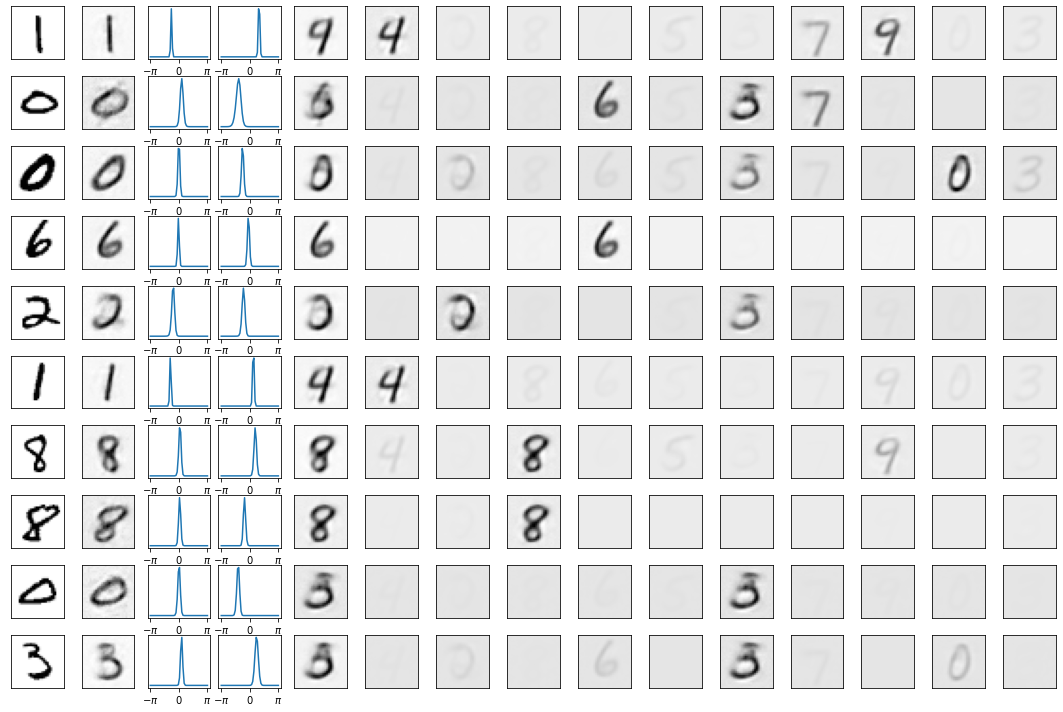

# Sparse Coding

In [30]:
def plot_sc_reconstruction(dl, show=False, save=None, M=10, expanded=True, box_margins=[0.05,0.95,0.95,0.075], hspace=0.35):
    # Generate Data
    y = next(iter(dl))[:M]

    alpha, res = sc.FISTA(y.t(),psi,lamb,steps,s,useMAGMA=True) # (K,B), (D,B)
    alpha, res = alpha.t(), res.t() # (B,K), (B,D)
    
    recon = torch.einsum('dk,bk->bd',psi,alpha)
    
    cols = 2
    fig = plt.figure(figsize=(cols,1.5*M))
    for i in range(M):
        fig.add_subplot(M,cols,i*cols+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(y[i].cpu().reshape((dim,dim)),cmap="Greys")
        fig.add_subplot(M,cols,i*cols+1+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(recon[i].cpu().reshape((dim,dim)),cmap="Greys")
#     plt.tight_layout()
    plt.subplots_adjust(left=box_margins[0], right=box_margins[1], top=box_margins[2], bottom=box_margins[3], hspace=hspace, wspace=0.5)
    if save is not None:
        plt.savefig(save.format(1))
    if show:
        plt.show()
    plt.close(fig)
    
    fig = plt.figure(figsize=(4.5,1.5*M))
    
    for i in range(M):
        fig.add_subplot(M,1,i+1)
        plt.xticks([])
        plt.yticks(fontsize='x-large')
        plt.xlim(-0.5,9.5)
        plt.bar(np.arange(alpha.size()[1]), alpha[i].cpu())
#         ax = plt.gca()
#         ax.margins(x=0.0)
#         ax.use_sticky_edges = False
#         ax.autoscale_view(scaley=True)
    plt.subplots_adjust(left=0.125, right=box_margins[1], top=box_margins[2], bottom=box_margins[3], hspace=hspace)
    if save is not None:
        plt.savefig(save.format(2))
    if show:
        plt.show()
    plt.close(fig)

In [31]:
B = 100

# Initialize dataloader
dl, test_dl, dim, D, num_train_batches, num_test_batches = get_MNIST_dataloader(B,cuda=True)
# dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dr=[-75.0,75.0],ds=[0.5,1.0],cuda=True) # Rotation and Scaling
# dl, test_dl, dim, D, num_train_batches, num_test_batches = get_custom_dataloader(B,dx=[-0.25,0.25],dy=[-0.25,0.25],cuda=True) # Horizontal and Vertical Translation

# Initialize sparse coding dictionary
K = 100
psi = torch.rand(D,K).cuda() # (D,K)
psi = f.normalize(psi, dim=0)

epoch, T = 0, 0

In [32]:
eta_psi = 0.05

s = 0.1
lamb = 1.0 # sparsity cost
epochs = 20 # 20000
save_skip = 100
steps = 20
hess = torch.zeros(K).cuda()
minact = 0.001
hist_len = 300.0
use_hess = False
shuffle = True
save = True
test = True
plot = False

In [33]:
# dataset_type = "sc_rot_75_scale_0.5-1.0_"
# dataset_type = "sc_ver_hor_"
dataset_type = "sc_"
new_dir = "data/{}MNIST{}x{}/s{}_B{}_K{}_lamb{}_epsi{}_steps{}".format(dataset_type,dim,dim,s,B,K,lamb,eta_psi,steps)
if use_hess:
    new_dir = new_dir + "_hess_minact{}_hist{}".format(minact,hist_len)
if shuffle:
    new_dir = new_dir + "_shuffle"
new_dir = new_dir + "_5"
if save:
    if not os.path.isdir("data/{}MNIST{}x{}".format(dataset_type,dim,dim)):
        os.mkdir("data/{}MNIST{}x{}".format(dataset_type,dim,dim))
    os.mkdir(new_dir)
    os.mkdir(new_dir + "/data")
    os.mkdir(new_dir + "/figures")
    os.mkdir(new_dir + "/videos")
data_path = new_dir + "/data/{}_epoch_{}.txt"
fig_path = new_dir + "/figures/{}_epoch_{}.png"
video_path = new_dir + "/videos/{}_epoch_{}_batch_{}.mp4"

In [34]:
while epoch < epochs:
    if shuffle:
        dl = dl.view(-1,dl.size()[-1])[torch.randperm(dl.size()[0]*dl.size()[1])].view(dl.size()) # shuffle
    # Reload dataloader
    it = iter(dl)
    test_it = iter(test_dl)
    
    # Training
    train_snr = 0.0
    while T < num_train_batches:
        t = int(epoch*num_train_batches+T+1)
        
        # Get data
        y = next(it) # (B,D)

        # Optimize alpha
        alpha, res = sc.FISTA(y.t(),psi,lamb,steps,s,useMAGMA=True,plot=plot) # (K,B), (D,B)
        alpha, res = alpha.t(), res.t() # (B,K), (B,D)
#         print(torch.isnan(alpha).any())

        # Calculate error
        snr = ((y**2).sum(dim=1)/(res**2).sum(dim=1)).mean()
        train_snr += snr
        
        hess = hess.mul((hist_len-1.0)/hist_len) + (alpha**2).mean(dim=0)/hist_len
        
        # Update psi
        if use_hess:
            old_psi = psi.clone()
            psi = sc.quadraticBasisUpdate(psi, res.t(), alpha.t(), minact, hess, eta_psi, s)
            if torch.isnan(psi).any():
                print("HI")
                psi = old_psi.clone()
            dpsi_length = torch.mean(torch.norm(psi - old_psi, dim=0))
        else:
            dpsi = eta_psi/s**2*(torch.einsum('bd,bk->dk',res,alpha)/B)
            new_psi = f.normalize(psi + dpsi, dim=0)
            dpsi_length = torch.mean(torch.norm(new_psi - psi, dim=0))
            psi = new_psi.clone()

        # Print error
        if T % save_skip == 0:
            print("Epoch {}, Batch {}: SNR1 - {:.3f}; Psi - {:.3f}".format(epoch, T, snr, dpsi_length))
        
        T += 1
    
    train_snr /= num_train_batches
    T = 0
    
    # Validation
    if test:
        test_snr = 0.0
        normed_psi = f.normalize(psi,dim=0)
        while T < num_test_batches:
            # Generate data
            y = next(test_it) # (B,D)

            # Optimize alpha
            alpha, res = sc.FISTA(y.t(),psi,lamb,steps,s,useMAGMA=True) # (K,B), (D,B)
            alpha, res = alpha.t(), res.t() # (B,K), (B,D)

            # Calculate error
            snr = ((y**2).sum(dim=1)/(res**2).sum(dim=1)).mean()
            test_snr += snr
            
            T += 1
            
        test_snr /= num_test_batches
        T = 0
        print("Epoch {}: Test SNR - {:.3f}".format(epoch, test_snr))
    
    epoch += 1
#     if epoch % 20 == 0:
#         eta_psi /= 2.0
    
    if save and test:
        # Save data
        np.savetxt(data_path.format("psi",epoch), psi.cpu().numpy())
        save_loss(train_snr, test_snr, new_dir + "/data/snr.txt")
        save_loss(alpha.norm(dim=1).mean().cpu().numpy(),0.0, new_dir + "/data/l1_norm.txt")

        # Plot figures
        plot_psi(psi,save=fig_path.format("psi",epoch))
#         plot_sc_reconstruction(dl, save=fig_path.format("recon",epoch))
        plot_sc_reconstruction(dl, save=fig_path.format("recon",epoch), expanded=False)

Epoch 0, Batch 0: SNR1 - 1.197; Psi - 0.012
Epoch 0, Batch 100: SNR1 - 3.873; Psi - 0.009
Epoch 0, Batch 200: SNR1 - 6.101; Psi - 0.011
Epoch 0, Batch 300: SNR1 - 7.079; Psi - 0.012
Epoch 0, Batch 400: SNR1 - 8.736; Psi - 0.013
Epoch 0, Batch 500: SNR1 - 9.471; Psi - 0.014
Epoch 0: Test SNR - 10.485
Epoch 1, Batch 0: SNR1 - 10.288; Psi - 0.015
Epoch 1, Batch 100: SNR1 - 10.434; Psi - 0.016
Epoch 1, Batch 200: SNR1 - 10.146; Psi - 0.018
Epoch 1, Batch 300: SNR1 - 10.968; Psi - 0.018
Epoch 1, Batch 400: SNR1 - 10.314; Psi - 0.023
Epoch 1, Batch 500: SNR1 - 10.802; Psi - 0.021
Epoch 1: Test SNR - 12.692
Epoch 2, Batch 0: SNR1 - 12.159; Psi - 0.013
Epoch 2, Batch 100: SNR1 - 13.299; Psi - 0.011
Epoch 2, Batch 200: SNR1 - 12.842; Psi - 0.011
Epoch 2, Batch 300: SNR1 - 12.962; Psi - 0.010
Epoch 2, Batch 400: SNR1 - 13.021; Psi - 0.010
Epoch 2, Batch 500: SNR1 - 12.632; Psi - 0.011
Epoch 2: Test SNR - 13.932
Epoch 3, Batch 0: SNR1 - 13.194; Psi - 0.011
Epoch 3, Batch 100: SNR1 - 13.301; Psi -